# LibPGM Benchmarking Runtime

Structure learning and CPD estimation algorithms have quite different complexity, this notebook contains routines to generate arbitrary BNs of varying num nodes and node complexity and then perform estimation benchmarking routines on them ...

In [1]:
# Imports
import random,json,copy,pprint,itertools,time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from libpgm.graphskeleton import GraphSkeleton
from libpgm.nodedata import NodeData
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.pgmlearner import PGMLearner


In [2]:

def is_parent(n,pn,edges):
    n_edges = filter(lambda x: x[0] == n, edges)
    for e in n_edges:
        if e[1] == pn:
            return True
        else:
            if is_parent(e[1],pn,edges):
                return True
    return False

def generate_random_dag(nodes=10):
    nodes = map(lambda x: chr(x), range(65,65+nodes))
    edges = []
    for n in nodes:
        nl = copy.copy(nodes)
        random.shuffle(nl)
        for pn in nl:
            if pn==n:
                continue
            if is_parent(pn,n,edges):
                continue
#            print "new parent edge (%s,%s)"%(n,pn)
            edges.append( [n,pn] )
            break
#        print n
    return nodes,edges


# Plot the learned BN graph
def plot_digraph(nodes,edges):
    
    # Set up the graph 
    G = nx.DiGraph()
    red_edges = edges
    G.add_edges_from(edges)
    labels = dict(zip(nodes,nodes))

    # Plots ...
    plt.figure()
    plt.axis('off')
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_nodes(G,pos,nodelist=nodes,node_color='g')
    nx.draw_networkx_labels(G,pos,labels,font_size=16)


def create_discrete_rvs(nodes, mincard=2, maxcard=30):
    word_file = "/usr/share/dict/words"
    words = open(word_file).read().splitlines()
    nodevals = {}
    for n in nodes:
        ncard = np.random.randint(mincard,maxcard)
        nodevals[n] = random.sample(words, ncard)
    return nodevals
        

In [3]:


def generate_random_bn(num_nodes=4, min_card=2, max_card=4):
    V,E = generate_random_dag(num_nodes)
    NV = create_discrete_rvs(V, min_card, max_card)

    graph = {
        "V": V,
        "E": E,
        "Vdata":{}
    }

    for n in V:
        parents = map(lambda x: x[1], filter(lambda x: x[0]==n, E))
        children = map(lambda x: x[0], filter(lambda x: x[1]==n, E))
        parentvals = map(lambda x: NV[x], parents)
        possible_conditions = list(itertools.product(*parentvals))
        noutcomes = len(NV[n])
        if(len(parents)==0):
            parents = None
        if(len(children)==0):
            children = None
        cprob = {}
        if len(possible_conditions) > 1:
            for condition_vals in possible_conditions:
                p = np.random.exponential(size=noutcomes)
                k = str(list(condition_vals))
                cprob[k] = list(p / np.sum(p))
        else:
            p = np.random.exponential(size=noutcomes)
            k = str(list(condition_vals))
            cprob = list(p / np.sum(p))

        nv = {
#        "ord":len(NV[n]),
            "numoutcomes":noutcomes,
            "vals":NV[n],
            "parents":parents,
            "children":children,
            "cprob":cprob
        }
        graph["Vdata"][n] = nv

        
    return graph

def plot_bn(graph):
    plot_digraph(graph['V'],graph['E'])


In [4]:

# Generate a libpgm BN from our model
def gen_discrete_bn(graph):
    skel = GraphSkeleton()
    skel.V = graph['V']
    skel.E = map(lambda x: [x[1],x[0]], graph['E'])
    skel.toporder()
    for i,n in enumerate(skel.V):
        graph["Vdata"][n]["ord"] = i            
    nd = NodeData()
    nd.Vdata = graph['Vdata']
    bn = DiscreteBayesianNetwork(skel, nd)
    return bn

def print_node_cardinalities(graph):
    print "Node Cardinalities..."
    for n in graph["V"]:
        print n,len(graph["Vdata"][n]['vals'])
        

Node Cardinalities...
A 14
B 6
C 15
D 29
E 12
F 15
G 13
H 24
I 5
J 28
K 29
L 27


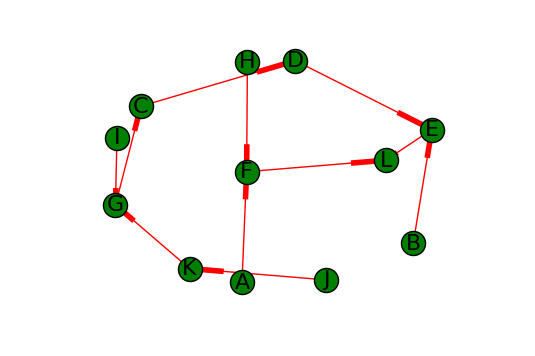

In [5]:
# Generate and Sample from random BN
n_nodes = 12
card_min = 2
card_max = 30

g = generate_random_bn(n_nodes,card_min,card_max)
plot_bn(g)
bn = gen_discrete_bn(g)
samples = bn.randomsample(1024*256, evidence={})
print_node_cardinalities(g)

In [6]:


s1 = [16,32,64,128,256,512,1024,2048,1024*4,1024*8,1024*16,1024*32,1024*64,1024*128,1024*256]
s2 = [16,32,64,128,256,512,1024,2048,1024*4,1024*8,1024*16,1024*32,1024*64,1024*128,1024*256]

learner = PGMLearner()

# Time the structure learning ...
structure_runtimes = []
cpd_runtimes = []
for s in s1:
    t1 = time.time()
    skel = learner.discrete_constraint_estimatestruct(samples[0:s])
    t2 = time.time()    
    structure_runtimes.append( t2-t1 )
    print "structure", s, t2-t1
    if (t2-t1) > 30:
        break;
    
for s in s2:
    t1 = time.time()
    bn = learner.discrete_mle_estimateparams(skel, samples[0:s])
    t2 = time.time()    
    cpd_runtimes.append( t2-t1 )
    print "cpd est", s, t2-t1
    

structure 16 1.16484498978
structure 32 3.10571098328
structure 64 4.84889793396
structure 128 6.75178718567
structure 256 11.5225250721
structure 512 15.9585499763
structure 1024 20.0356709957
structure 2048 21.1218419075
structure 4096 26.4287619591
structure 8192 36.5163722038
cpd est 16 0.00557398796082
cpd est 32 0.0132420063019
cpd est 64 0.0593898296356
cpd est 128 0.0306370258331
cpd est 256 0.0301830768585
cpd est 512 0.0400650501251
cpd est 1024 0.113594055176
cpd est 2048 0.0883829593658
cpd est 4096 0.151146173477
cpd est 8192 0.296270847321
cpd est 16384 0.522474050522
cpd est 32768 1.06613516808
cpd est 65536 2.02082204819
cpd est 131072 4.6370241642
cpd est 262144 8.8541560173


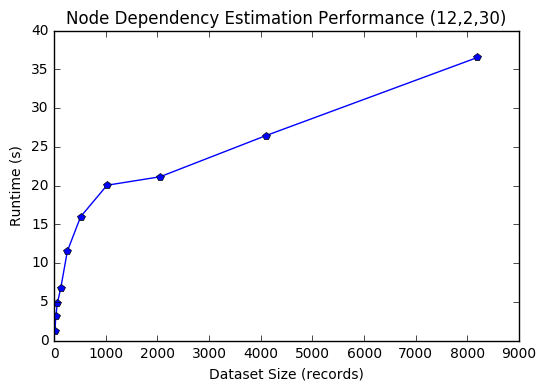

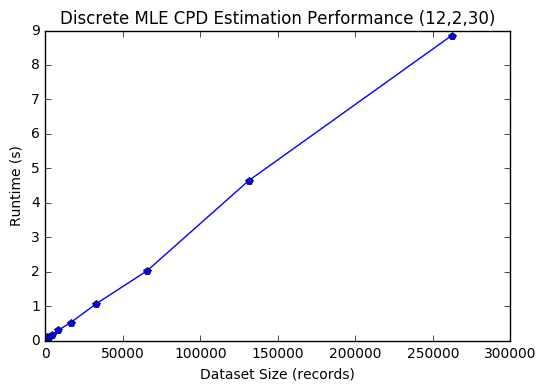

In [8]:
plt.figure()
plt.plot(s1[0:len(structure_runtimes)], structure_runtimes,'p-')
plt.xlabel("Dataset Size (records)")
plt.ylabel("Runtime (s)")
plt.title("Node Dependency Estimation Performance (%d,%d,%d)"%(n_nodes,card_min,card_max))
plt.figure()
plt.plot(s2, cpd_runtimes,'p-')
plt.xlabel("Dataset Size (records)")
plt.ylabel("Runtime (s)")
plt.title("Discrete MLE CPD Estimation Performance (%d,%d,%d)"%(n_nodes,card_min,card_max))

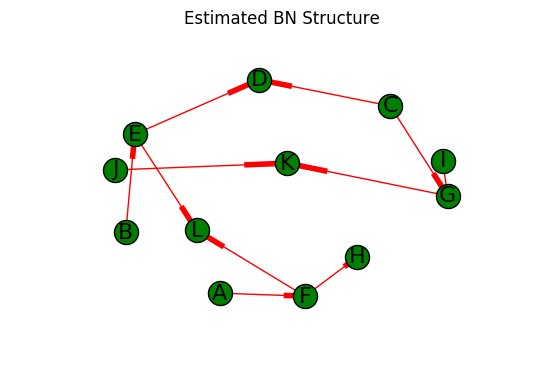

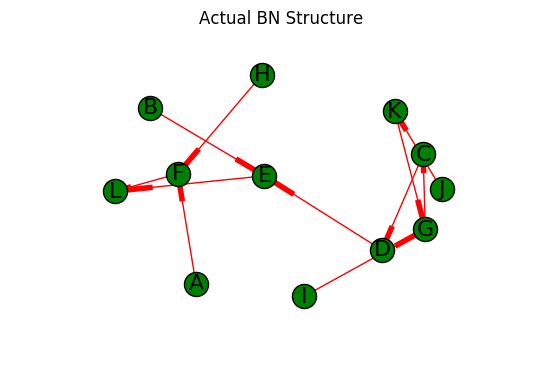

In [9]:
# Plot the learned BN graph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Set up the graph 
G = nx.DiGraph()
red_edges = bn.E
G.add_edges_from(bn.E)
usednodes = []
for edge in bn.E:
    usednodes.append(edge[0])
    usednodes.append(edge[1])
usednodes = list(set(usednodes))
values = usednodes
labels = dict(zip(values,values))

# Plots ...
plt.figure()
plt.axis('off')
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_nodes(G,pos,nodelist=values,node_color='g')
nx.draw_networkx_labels(G,pos,labels,font_size=16)
plt.title("Estimated BN Structure")

plot_bn(g)
plt.title("Actual BN Structure")

In [10]:
print "Ground Truth... "
pprint.pprint(g)

Ground Truth... 
{'E': [['A', 'F'],
       ['B', 'E'],
       ['C', 'D'],
       ['D', 'E'],
       ['E', 'L'],
       ['F', 'L'],
       ['G', 'C'],
       ['H', 'F'],
       ['I', 'G'],
       ['J', 'K'],
       ['K', 'G']],
 'V': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'],
 'Vdata': {'A': {'children': None,
                 'cprob': {'["Tevet\'s"]': [0.0093074080572645764,
                                            0.098775138524216932,
                                            0.11728626786344731,
                                            0.2434481453470031,
                                            0.13773709467590864,
                                            0.023320528694687169,
                                            0.0050568379933557134,
                                            0.13718069500507982,
                                            0.18408872358120557,
                                            0.019377677445706024,
              

In [11]:
print "Estimated Model"
pprint.pprint(bn.Vdata)

Estimated Model
{'A': {'children': ['F'],
       'cprob': [0.10976028442382812,
                 0.07863235473632812,
                 0.049434661865234375,
                 0.11225509643554688,
                 0.044414520263671875,
                 0.09970855712890625,
                 0.061954498291015625,
                 0.11138534545898438,
                 0.054485321044921875,
                 0.0457611083984375,
                 0.06396865844726562,
                 0.06377792358398438,
                 0.07093048095703125,
                 0.03353118896484375],
       'numoutcomes': 14,
       'parents': [],
       'vals': ['officeholder',
                'hashing',
                'innkeepers',
                'styli',
                'evaporate',
                'bilking',
                'hibachi',
                'carpenters',
                'lichees',
                "drowse's",
                'aerodynamic',
                'snuffles',
                'reliant',
      

In [12]:
import cPickle
cPickle.dump( samples, open("sample.dat",'wb') )